In [ ]:
!pip install -U braindecode==1.2.0 mne==1.10.1 mne-bids==0.17.0 --quiet
!pip install -U eegdash==0.3.8 s3fs==2025.9.0 fsspec==2025.9.0 pandas==2.3.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 138.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have panda

In [ ]:
from pathlib import Path
import os, math, random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from sklearn.preprocessing import StandardScaler

from braindecode.preprocessing import create_fixed_length_windows
from braindecode.datasets.base import BaseConcatDataset, BaseDataset, EEGWindowsDataset
from braindecode.models import EEGNetv4  # EEGNet architecture implemented in Braindecode

from eegdash import EEGChallengeDataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all(42)
print("Device:", device)

# Sampling rate defined early
SFREQ = 100  # competition downsampled rate

Device: cuda


Loading data for one release

In [ ]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Official split
train_releases = ["R1", "R2", "R3", "R4", "R6", "R7", "R8", "R9", "R10", "R11"]
val_releases   = ["R5"]
# test_releases  = ["R12"]  # R12 available only on cluster; code submission needed

task_name = "contrastChangeDetection"
mini_mode = True  # keep True for Colab/Kaggle; set False on a server with more RAM/disk

desc_fields = ["subject","session","run","task","age","sex","gender","handedness","p_factor"]

# Build training dataset by concatenating all training releases
print("Loading training releases:", train_releases)
train_list = [
    EEGChallengeDataset(
        release=rel,
        task=task_name,
        mini=mini_mode,
        description_fields=desc_fields,
        cache_dir=DATA_DIR,
    )
    for rel in train_releases
]
train_bcd_raw = BaseConcatDataset(train_list)
print("Raw train rows:", len(train_bcd_raw.datasets))

# Build validation dataset from R5
print("Loading validation release:", val_releases)
val_list = [
    EEGChallengeDataset(
        release=rel,
        task=task_name,
        mini=mini_mode,
        description_fields=desc_fields,
        cache_dir=DATA_DIR,
    )
    for rel in val_releases
]
val_bcd_raw = BaseConcatDataset(val_list)
print("Raw val rows:", len(val_bcd_raw.datasets))


Loading training releases: ['R1', 'R2', 'R3', 'R4', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']


/usr/local/lib/python3.12/dist-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(
/usr/local/lib/python3.12/dist-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 

Raw train rows: 597
Loading validation release: ['R5']


/usr/local/lib/python3.12/dist-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Raw val rows: 60


Filtering and splitting

In [ ]:
sub_rm =[]

def filter_dataset(bcd: BaseConcatDataset):
    kept = []
    for ds in bcd.datasets:
        ok = (
            ds.description["subject"] not in sub_rm
            and not math.isnan(float(ds.description.get("p_factor", np.nan)))
            and ds.raw.n_times >= 4 * SFREQ
            and len(ds.raw.ch_names) == 129
        )
        if ok:
            kept.append(ds)
    return BaseConcatDataset(kept)

train_bcd = filter_dataset(train_bcd_raw)
val_bcd   = filter_dataset(val_bcd_raw)

print("Filtered train rows:", len(train_bcd.datasets))
print("Filtered val rows:", len(val_bcd.datasets))

# Count unique subjects per split
train_subjects = set(ds.description["subject"] for ds in train_bcd.datasets)
val_subjects   = set(ds.description["subject"] for ds in val_bcd.datasets)
print(f"Train subjects: {len(train_subjects)} | Val subjects: {len(val_subjects)}")


Streaming output truncated to the last 5000 lines.

Filtered train rows: 597
Filtered val rows: 57
Train subjects: 199 | Val subjects: 19


In [ ]:
import pickle
from pathlib import Path

# Save filtered datasets
train_cache = Path("data/train_bcd_filtered.pkl")
val_cache = Path("data/val_bcd_filtered.pkl")

train_cache.parent.mkdir(parents=True, exist_ok=True)

print("Saving filtered datasets...")
with open(train_cache, "wb") as f:
    pickle.dump(train_bcd, f)
with open(val_cache, "wb") as f:
    pickle.dump(val_bcd, f)
print(f"Saved to {train_cache} and {val_cache}")
print("Next time, load these instead of re-filtering.")


Saving filtered datasets...
Saved to data/train_bcd_filtered.pkl and data/val_bcd_filtered.pkl
Next time, load these instead of re-filtering.


In [ ]:
print("Sample train subjects:", list(train_subjects)[:5])
print("Sample val subjects:", list(val_subjects)[:5])

# Label histogram for training
train_labels = np.array([float(ds.description["p_factor"]) for ds in train_bcd.datasets], dtype=np.float32)
val_labels   = np.array([float(ds.description["p_factor"]) for ds in val_bcd.datasets], dtype=np.float32)
print("Train p_factor: mean={:.3f}, std={:.3f}".format(train_labels.mean(), train_labels.std()))
print("Val p_factor: mean={:.3f}, std={:.3f}".format(val_labels.mean(), val_labels.std()))


Sample train subjects: ['NDARAP359UM6', 'NDAREK549XUQ', 'NDARBT640EBN', 'NDAREV527ZRF', 'NDARAD571FLB']
Sample val subjects: ['NDARAU708TL8', 'NDARBM433VER', 'NDARBE103DHM', 'NDARDH086ZKK', 'NDARDC843HHM']
Train p_factor: mean=-0.062, std=0.807
Val p_factor: mean=-0.003, std=0.831


Dataset wrapper w/ demographics

In [ ]:
class DatasetWrapper(BaseDataset):

    def __init__(self, dataset: EEGWindowsDataset, crop_size_samples: int, seed=None):
        self.dataset = dataset
        self.crop_size_samples = crop_size_samples
        self.rng = random.Random(seed)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        X, _, crop_inds = self.dataset[index]

        # Label
        y = torch.tensor(float(self.dataset.description["p_factor"]), dtype=torch.float32)

        # Build full demo = [age, sex, hand]
        age = self.dataset.description.get("age", np.nan)
        age = float(age) if age is not None and age == age else np.nan
        sex_str = str(self.dataset.description.get("sex", self.dataset.description.get("gender", ""))).strip().lower()
        sex = 1.0 if sex_str in ["female","f","2"] else 0.0 if sex_str not in ["", "nan"] else np.nan
        hand = self.dataset.description.get("handedness", np.nan)
        hand = float(hand) if hand is not None and hand == hand else np.nan

        full_demo = np.array([age, sex, hand], dtype=np.float32)

        # Select only kept columns
        if demo_dim > 0:
            demo_np = full_demo[keep_idx]
            # Do not impute here; raw NaNs will be handled in transform function
            demo = torch.from_numpy(demo_np)
        else:
            demo = torch.empty(0, dtype=torch.float32)  # zero-dim


        infos = {
            "subject": self.dataset.description["subject"],
            "task": self.dataset.description["task"],
            "session": self.dataset.description.get("session", "") or "",
            "run": self.dataset.description.get("run", "") or "",
        }

        # Random 2 s crop inside a 4 s window
        i_window_in_trial, i_start, i_stop = crop_inds
        crop_len = 2 * SFREQ
        assert (i_stop - i_start) >= crop_len, f"Window too short: {(i_stop - i_start)} < {crop_len}"
        start_offset = self.rng.randint(0, (i_stop - i_start) - crop_len)
        X = X[:, start_offset : start_offset + crop_len]  # X may be numpy here

        # Convert to torch tensor (C, T) float32
        if not torch.is_tensor(X):
            X = torch.from_numpy(np.asarray(X))

        X = X.to(torch.float32)

        # Per-window standardization with epsilon, then sanitize
        mu = X.mean(dim=1, keepdim=True)
        sd = X.std(dim=1, keepdim=True)
        X = (X - mu) / (sd + 1e-6)

        # Replace NaN/Inf with zeros and clamp extreme amplitudes
        X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X = torch.clamp(X, min=-1e3, max=1e3)

        return X, y, demo, (i_window_in_trial, i_start, i_stop), infos


Fit demo scaler on train subjects

In [ ]:
# Extract unique demographics from train_bcd for scaler fitting
def extract_unique_demo(bcd: BaseConcatDataset):
    seen = {}
    for ds in bcd.datasets:
        sid = ds.description["subject"]
        if sid in seen:
            continue
        age = ds.description.get("age", np.nan)
        age = float(age) if age is not None and age == age else np.nan
        sex_str = str(ds.description.get("sex", ds.description.get("gender", ""))).strip().lower()
        sex = 1.0 if sex_str in ["female","f","2"] else 0.0 if sex_str else np.nan
        hand = ds.description.get("handedness", np.nan)
        hand = float(hand) if hand is not None and hand == hand else np.nan
        seen[sid] = [age, sex, hand]
    arr = np.array(list(seen.values()), dtype=np.float32) if seen else np.zeros((0,3), dtype=np.float32)
    return arr

train_demo_unique = extract_unique_demo(train_bcd)
if train_demo_unique.shape[0] == 0:
    train_demo_unique = np.zeros((1,3), dtype=np.float32) * np.nan

# Detect all-NaN columns and keep only usable ones
all_nan_cols = np.isnan(train_demo_unique).all(axis=0)
keep_mask = ~all_nan_cols
keep_names = [n for n, k in zip(["age","sex","hand"], keep_mask) if k]
keep_idx = np.where(keep_mask)[0]
print("Keeping demo columns:", keep_names)

train_demo_kept = train_demo_unique[:, keep_idx]
if train_demo_kept.shape[1] == 0:
    print("No usable demographic columns; disabling late fusion.")
    demo_dim = 0
else:
    demo_dim = train_demo_kept.shape[1]

if demo_dim > 0:
    with np.errstate(all="ignore"):
        col_medians = np.nanmedian(train_demo_kept, axis=0).astype(np.float32)
    col_medians[~np.isfinite(col_medians)] = 0.0

    def impute_cols(arr, meds):
        out = arr.copy()
        for j in range(out.shape[1]):
            mask = ~np.isfinite(out[:, j])
            out[mask, j] = meds[j]
        return out

    train_demo_imp = impute_cols(train_demo_kept, col_medians)

    class SafeStandardScaler(StandardScaler):
        def fit(self, X, y=None):
            super().fit(X, y)
            if hasattr(self, "scale_"):
                bad = ~np.isfinite(self.scale_) | (self.scale_ == 0)
                self.scale_[bad] = 1.0
            if hasattr(self, "var_"):
                self.var_[~np.isfinite(self.var_)] = 0.0
            if hasattr(self, "mean_"):
                self.mean_[~np.isfinite(self.mean_)] = 0.0
            return self

    demo_scaler = SafeStandardScaler().fit(train_demo_imp)
    print("Demo scaler fitted on", train_demo_imp.shape[0], "training subjects | dims:", demo_dim)
else:
    demo_scaler = None
    col_medians = np.zeros(0, dtype=np.float32)

@torch.no_grad()
def transform_demo_batch(demo_t: torch.Tensor):

    dev = torch.device(device) if not isinstance(device, torch.device) else device

    # If demographics were dropped (demo_dim=0), return empty tensor
    if demo_t.numel() == 0:
        return demo_t.to(device=dev)

    # Convert to numpy, impute, scale
    demo_np = demo_t.detach().cpu().numpy().astype(np.float32)

    # Impute with col_medians (one per kept column)
    for j in range(demo_np.shape[1]):
        mask = ~np.isfinite(demo_np[:, j])
        demo_np[mask, j] = col_medians[j] if j < len(col_medians) else 0.0

    # Scale using fitted scaler
    demo_np = demo_scaler.transform(demo_np)

    # Convert back to torch and sanitize
    demo = torch.from_numpy(demo_np).to(device=dev, dtype=torch.float32)
    demo = torch.nan_to_num(demo, nan=0.0, posinf=0.0, neginf=0.0)

    return demo


Keeping demo columns: ['age', 'sex']
Demo scaler fitted on 199 training subjects | dims: 2


Windowing and DataLoaders

In [ ]:
def make_windows(bcd: BaseConcatDataset, crop_seconds=2):
    windows = create_fixed_length_windows(
        bcd,
        window_size_samples=4 * SFREQ,
        window_stride_samples=2 * SFREQ,
        drop_last_window=True,
    )
    wrapped = [DatasetWrapper(ds, crop_size_samples=crop_seconds * SFREQ, seed=42) for ds in windows.datasets]
    return BaseConcatDataset(wrapped)

train_windows = make_windows(train_bcd, crop_seconds=2)
val_windows   = make_windows(val_bcd,   crop_seconds=2)

num_workers = 1
batch_size = 128  # or 32/64 depending on GPU memory
train_loader = DataLoader(train_windows, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_windows,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))


Train batches: 765 | Val batches: 65


Visualization

Sample window: torch.Size([129, 200]) y: -0.6029999852180481 demo: [11.3386  1.    ] subject: NDARAC904DMU


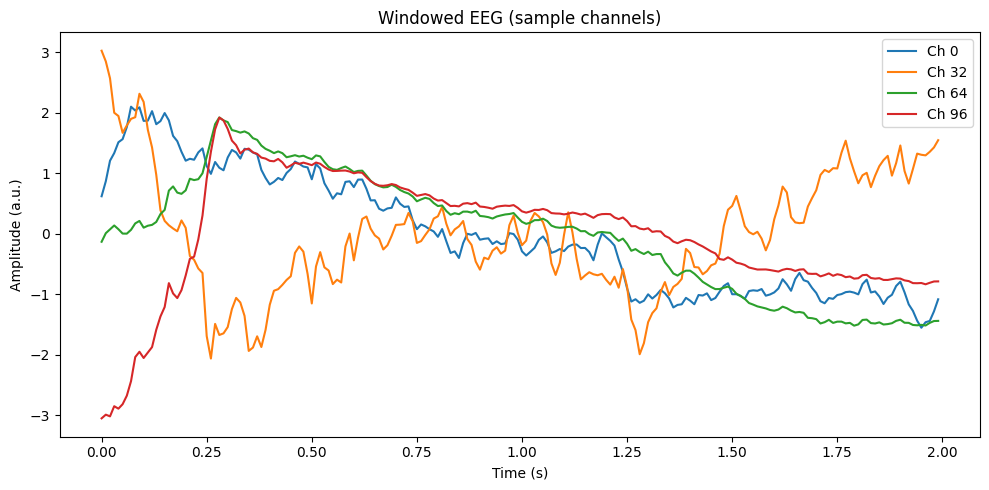

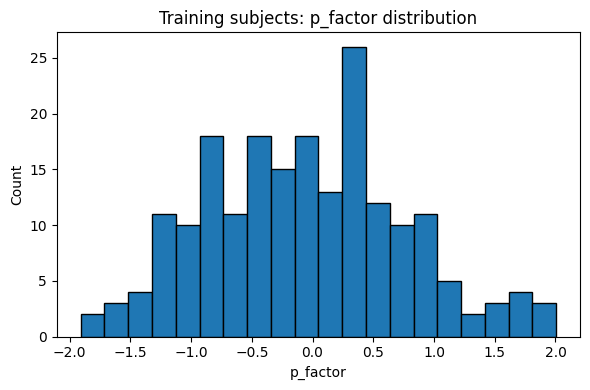

In [ ]:
# Sample a window and plot channels
if len(train_windows.datasets) > 0:
    sample_ds = train_windows.datasets[0]
    X_win, y_win, demo_win, _, info_win = sample_ds[0]
    print("Sample window:", X_win.shape, "y:", float(y_win), "demo:", demo_win.numpy(), "subject:", info_win["subject"])

    t = np.arange(X_win.shape[1]) / SFREQ
    plt.figure(figsize=(10, 5))
    for ch in [0, 32, 64, 96]:
        if ch < X_win.shape[0]:
            plt.plot(t, X_win[ch], label=f"Ch {ch}")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude (a.u.)"); plt.title("Windowed EEG (sample channels)")
    plt.legend(); plt.tight_layout(); plt.show()

# Histogram of training p_factor (unique subjects)
def unique_subject_labels(bcd):
    seen = {}
    for ds in bcd.datasets:
        sid = ds.description["subject"]
        if sid not in seen:
            seen[sid] = float(ds.description["p_factor"])
    return np.array(list(seen.values()), dtype=np.float32) if seen else np.zeros((0,), dtype=np.float32)

train_labels = unique_subject_labels(train_bcd)
if train_labels.size > 0:
    plt.figure(figsize=(6,4))
    plt.hist(train_labels, bins=20, edgecolor="black")
    plt.xlabel("p_factor"); plt.ylabel("Count"); plt.title("Training subjects: p_factor distribution")
    plt.tight_layout(); plt.show()

EEGNetv4 + demographics late fusion

In [ ]:
class EEGNetWithDemo(nn.Module):
    def __init__(self, n_chans, n_times, demo_dim=3, feat_dim=16, drop_prob=0.5):
        super().__init__()
        self.backbone = EEGNetv4(n_chans=n_chans, n_outputs=feat_dim, n_times=n_times, drop_prob=drop_prob)
        self.head = nn.Sequential(
            nn.Linear(feat_dim + demo_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
        )
    def forward(self, x, demo):
        feat = self.backbone(x)             # [B, feat_dim]
        z = torch.cat([feat, demo], dim=1)  # [B, feat_dim + demo_dim]
        return self.head(z)                 # [B, 1]

if demo_dim > 0:
    model = EEGNetWithDemo(n_chans=129, n_times=2 * SFREQ, demo_dim=demo_dim, feat_dim=16, drop_prob=0.5).to(device)
else:
    # EEG-only: set EEGNetv4 to output 1 directly or keep feat_dim + head with demo_dim=0
    class EEGOnly(nn.Module):
        def __init__(self, n_chans, n_times, feat_dim=16, drop_prob=0.5):
            super().__init__()
            self.backbone = EEGNetv4(n_chans=n_chans, n_outputs=feat_dim, n_times=n_times, drop_prob=drop_prob)
            self.head = nn.Sequential(nn.Linear(feat_dim, 64), nn.ReLU(inplace=True), nn.Dropout(p=0.25), nn.Linear(64, 1))
        def forward(self, x):
            feat = self.backbone(x)
            return self.head(feat)
    model = EEGOnly(n_chans=129, n_times=2 * SFREQ, feat_dim=16, drop_prob=0.5).to(device)

optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=1e-3)
criterion = torch.nn.MSELoss()  # aligns with RMSE/nRMSE scoring
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-5)
print(model)

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


EEGNetWithDemo(
  (backbone): EEGNetv4(
    (ensuredims): Ensure4d()
    (dimshuffle): Rearrange('batch ch t 1 -> batch 1 ch t')
    (conv_temporal): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (bnorm_temporal): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv_spatial): ParametrizedConv2dWithConstraint(
      8, 16, kernel_size=(129, 1), stride=(1, 1), groups=8, bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): MaxNormParametrize()
        )
      )
    )
    (bnorm_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (elu_1): ELU(alpha=1.0)
    (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (drop_1): Dropout(p=0.5, inplace=False)
    (conv_separable_depth): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (conv_separable_point): Conv2d(16, 16, kernel_si

Validation: subject-level nRMSE

In [ ]:
@torch.no_grad()
def evaluate_subject_nrmse(model, loader):
    model.eval()
    dev = torch.device(device) if not isinstance(device, torch.device) else device
    subj_pred, subj_true = defaultdict(list), {}

    # Progress bar for validation batches
    pbar = tqdm(loader, desc="Validation", leave=False)
    for X, y, demo, crop_inds, infos in pbar:
        X = X.to(device=dev, dtype=torch.float32)
        y = y.to(device=dev, dtype=torch.float32).view(-1, 1)
        demo = transform_demo_batch(demo)
        if demo.device != dev:
            demo = demo.to(device=dev, dtype=torch.float32)

        preds = model(X, demo).squeeze(1).detach().cpu().numpy()
        ys    = y.squeeze(1).detach().cpu().numpy()

        subjects = [d["subject"] for d in infos] if isinstance(infos, list) else infos["subject"]
        if not isinstance(subjects, (list, tuple, np.ndarray)):
            subjects = [subjects] * len(preds)

        for i, sid in enumerate(subjects):
            subj_pred[sid].append(float(preds[i]))
            subj_true[sid] = float(ys[i])

    # Aggregate and compute nRMSE
    y_true, y_hat, sids = [], [], []
    for sid, pred_list in subj_pred.items():
        if sid not in subj_true or len(pred_list) == 0:
            continue
        y_true.append(subj_true[sid])
        y_hat.append(float(np.mean(pred_list)))
        sids.append(sid)

    y_true = np.array(y_true, dtype=np.float64)
    y_hat  = np.array(y_hat,  dtype=np.float64)
    if len(y_true) == 0:
        return np.nan, np.nan, np.nan, 0

    rmse  = np.sqrt(np.mean((y_true - y_hat) ** 2))
    std_y = np.std(y_true, ddof=0)
    nrmse = rmse / std_y if std_y > 0 else np.nan

    # Save CSV
    out_path = Path("outputs"); out_path.mkdir(parents=True, exist_ok=True)
    pd.DataFrame({"subject": sids, "p_factor_pred": y_hat}).to_csv(out_path / "val_subject_predictions.csv", index=False)

    return nrmse, rmse, std_y, len(sids)


Training with early stopping

In [ ]:
from tqdm.auto import tqdm

n_epochs = 40
best_nrmse = float("inf")
patience = 8
wait = 0

ckpt_dir = Path("checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / "best_eegnet_demo_r5.pt"

for epoch in range(1, n_epochs + 1):
    # Train
    model.train()
    train_loss_sum, train_count = 0.0, 0
    for X, y, demo, crop_inds, infos in tqdm(train_loader, desc=f"Epoch {epoch:02d} Train", leave=False):
        optimizer.zero_grad()
        X = X.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.float32).view(-1, 1)
        demo = demo.to(device=device, dtype=torch.float32)
        y_pred = model(X, demo)
        loss = criterion(y_pred, y)
        if not torch.isfinite(y_pred).all() or not torch.isfinite(y).all():
          print("Non-finite detected:", torch.isnan(y_pred).sum().item(), torch.isinf(y_pred).sum().item())
          continue

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_sum += loss.item() * X.size(0)
        train_count += X.size(0)
    train_mse = train_loss_sum / max(1, train_count)

    # Validate (subject-level on R5 split)
    nrmse, rmse, std_y, n_subj = evaluate_subject_nrmse(model, val_loader)
    scheduler.step(nrmse if nrmse == nrmse else 1.0)

    print(f"Epoch {epoch:02d} | train MSE={train_mse:.4f} | val nRMSE={nrmse:.4f} | RMSE={rmse:.4f} | std(y)={std_y:.4f} | subjects={n_subj}")

    # Early stopping
    if nrmse < best_nrmse:
        best_nrmse = nrmse
        wait = 0
        torch.save({"model": model.state_dict(), "best_nrmse": best_nrmse}, ckpt_path)
        print(f"  Saved: {ckpt_path} (best nRMSE={best_nrmse:.4f})")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch} (best nRMSE={best_nrmse:.4f})")
            break
torch.save(model.state_dict(), "best_eegnet_demo_2.pt")
torch.save({"model": model.state_dict(), "optimizer": optimizer.state_dict(), "scaler_mean": demo_scaler.mean_, "scaler_scale": demo_scaler.scale_, "medians": medians}, "best_ckpt.pt")
